# 18. [Neural Networks 神經網路](https://github.com/joelgrus/data-science-from-scratch/blob/master/code/neural_networks.py)

In [20]:
%pylab inline
from sympy import *
init_printing(use_unicode=True)
 
from sympy.plotting import plot

Populating the interactive namespace from numpy and matplotlib


/home/wei/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diag', 'Circle', 'conjugate', 'roots', 'seterr', 'eye', 'solve', 'gamma', 'Polygon', 'test', 'sinh', 'power', 'zeros', 'transpose', 'interactive', 'prod', 'cosh', 'det', 'source', 'cbrt', 'vectorize', 'trace', 'mod', 'floor', 'cos', 'pi', 'sinc', 'invert', 'poly', 'nan', 'deprecated', 'var', 'plotting', 'sqrt', 'beta', 'tanh', 'take', 'reshape', 'multinomial', 'sin', 'log', 'sign', 'trunc', 'product', 'plot', 'add', 'flatten', 'exp', 'binomial', 'ones', 'tan', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
# import matplotlib
# import matplotlib.pyplot as plt

In [5]:
from __future__ import division
from collections import Counter
from functools import partial
from linear_algebra import dot
import math, random
import matplotlib
import matplotlib.pyplot as plt
import json

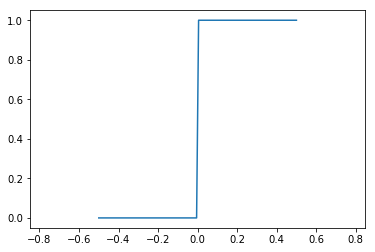

In [6]:
def step_function(x):
    return 1 if x >= 0 else 0

x = np.linspace(-.5, .5, 100)
plt.plot(x, list(map(step_function, x)))
plt.axis('equal');

In [7]:
def perceptron_output(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    return step_function(dot(weights, x) + bias)

weights = [2, 2]
bias = -3
x = [1, 1]

print('dot(weights, x) + bias:', dot(weights, x) + bias)
perceptron_output(weights, bias, x)

dot(weights, x) + bias: 1


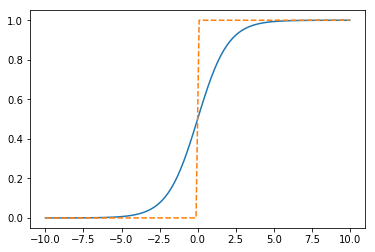

In [8]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

x = np.linspace(-10, 10, 100)
plt.plot(x, list(map(sigmoid, x)))
plt.plot(x, list(map(step_function, x)), '--'); 

In [11]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

weights = [2, 2] 
x = [1, 1]

neuron_output(weights, x)

In [12]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""

    outputs = []

    for layer in neural_network:

        input_with_bias = input_vector + [1]             # add a bias input
        output = [neuron_output(neuron, input_with_bias) # compute the output 
                  for neuron in layer]                   # for this layer
                    # 這邊的 "neuron" 代表的 其實是一組 weight        
        outputs.append(output)                           # and remember it

        # the input to the next layer is the output of this one
        input_vector = output

    return outputs

In [13]:
xor_network = [# 隱藏層
                [
                    [20, 20, -30],  # AND 神經元 的 weights 陣列
                    [20, 20, -10]   # OR  神經元 的 weights 陣列
                ], 
                 # 輸出層
                [
                    [-60, 60, -30]  # "第二輸入 AND NOT 第一輸入" 神經元 的 weights 陣列
                ]
              ] 

# 驗證 XOR gate 的特性
for x in [0, 1]:
    for y in [0, 1]:
        print(x, y , feed_forward(xor_network, [x, y])[-1])

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


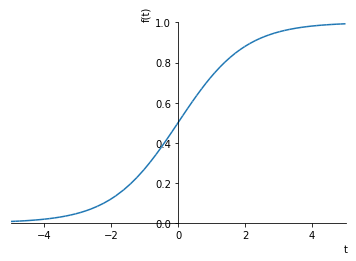

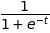

In [94]:
# sigmod 的函數

t = symbols('t', real = True)
expr_sigmoid = 1 / (1 + exp(-t))
# expr_sigmoid = simplify(expr_sigmoid)
plot(expr_sigmoid, (t, -5, 5));
expr_sigmoid

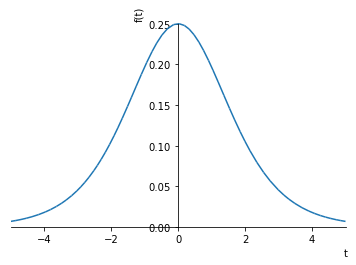

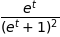

In [89]:
# sigmoid 的導函數 
    
expr_simoid_prime = Derivative(expr_sigmoid, t).doit()
expr_simoid_prime = simplify(expr_simoid_prime)
plot(expr_simoid_prime, (t, -5, 5));
expr_simoid_prime

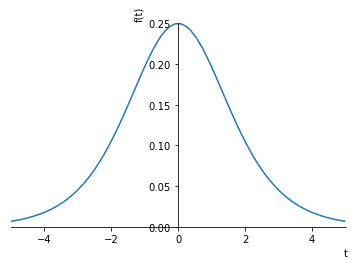

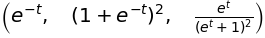

In [97]:
# sigmoid 的導函數 = (1 - sigmoid) * sigmoid

# expr_nu = (1 / expr_sigmoid) - 1 
expr_nu = (1 - expr_sigmoid) / expr_sigmoid
expr_nu = simplify(expr_nu)

expr_de = (1 / expr_sigmoid)**2
expr_de = 1 / expr_sigmoid**2

expr = expr_nu / expr_de
expr = (1 - expr_sigmoid) * expr_sigmoid  # sigmoid 的導函數 = (1 - sigmoid) * sigmoid
expr = simplify(expr)

plot(expr, (t, -5, 5));
expr_nu, expr_de, expr

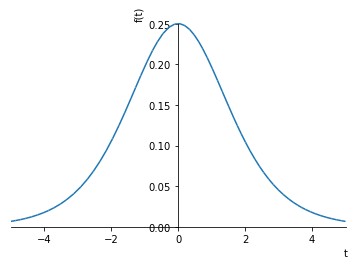

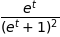

In [98]:
# sigmoid 的導函數 = (1 - sigmoid) * sigmoid

plot(expr, (t, -5, 5));
simplify((expr_sigmoid) * (1- expr_sigmoid))

In [119]:
def backpropagate(network, input_vector, target):

    # input_vector 經過 network 之後，hidden layer 和 output layer 的輸出
    hidden_outputs, outputs = feed_forward(network, input_vector)
    
    # the output * (1 - output) is from the derivative of sigmoid
    # output * (1 - output) 是來自於 sigmoid 的導函數
    # sigmoid 的導函數 = (1 - sigmoid) * sigmoid
    # deltas = (output layer 每個 neuron 的 output 和 target 的誤差) * sigmoid 的導數(gradient)
    # 單單這一次循環，經過修正 weight之後，output layer 的 raw輸出 應該要有的修正量
    # (output * (1 - output)) 已知的情況下: 
    #   (output - target[i])越大，表示 output layer 的 raw輸出 偏離應有的值越多，
    #   因此，以 (output * (1 - output)) * (output - target[i]) 求出 output layer 的 raw輸出 應該要有的修正量
    # output_deltas: output layer 的 raw輸出 應該要有的修正量
    output_deltas = [(output * (1 - output)) * (output - target[i])
                     for i, output in enumerate(outputs)]
                     
    # adjust weights for output layer (network[-1])
    # 調整由 hidden layer 到 output layer 的 weights，一次一個神經元
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            # 調整第 j 個權重值，根據此神經元的 delta，以及它的第 j 個輸入
            # output_neuron的 output_neuron[j] 這個 weight，該有的調整量 =  - output_deltas[i] * hidden_output
            # weight_delta = - output_deltas[i] * hidden_output
            # weight_delta / hidden_output = - output_deltas[i] 
            # output_deltas[i] 代表 output layer 的 raw輸出 應該要有的修正量:
            #   如果 hidden_output 已知，output_deltas[i] 越大，則代表 output_neuron[j] 這個 weight 該有的調整量越大
            #   如果 output_deltas[i] 已知，hidden_output 越大，則代表 output_neuron[j] 這個 weight 越重要，則該有的調整量越大
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    # 反向傳播到 hidden layer
    # output_deltas: output layer 的 raw輸出 應該要有的修正量
    # hidden_layer 的輸出應該要調整
    # 給定 output_deltas = (output layer 的 raw輸出 應該要有的修正量) 之下，
    #   (hidden layer sigmoid 輸出的誤差量) = (dot(output_deltas, [n[i] for n in network[-1]]))
    #   一個 hidden layer 的神經元 H_j，其 sigmoid輸出的誤差 乘上 output layer 神經元上的 weights 之後，造成 output_deltas
    #   所以 H_j sigmoid輸出的誤差 = dot(output_deltas, output layer 神經元上的 weights) = (dot(output_deltas, [n[i] for n in network[-1]]))
    乘上 output layer 各個神經元上對應 weight[j]
    hidden_deltas = [(hidden_output * (1 - hidden_output)) * dot(output_deltas, [n[i] for n in network[-1]]) 
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer (network[0])
    # 調整由 input layer 到 hidden layer 的 weights，一次一個神經元
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

In [105]:
def show_weights(network, neuron_idx, ax = None):
    weights = network[0][neuron_idx]
    abs_weights = list(map(abs, weights))

    grid = [abs_weights[row:(row+5)] # turn the weights into a 5x5 grid
            for row in range(0,25,5)] # [weights[0:5], ..., weights[20:25]]

    if ax is None: ax = plt.gca() # to use hatching, we'll need the axis

    ax.imshow(grid, # here same as plt.imshow
              cmap=matplotlib.cm.binary, # use white-black color scale
              interpolation='none') # plot blocks as blocks

    # cross-hatch the negative weights
    for i in range(5): # row
        for j in range(5): # column
            if weights[5*i + j] < 0: # row i, column j = weights[5*i + j]
                # add black and white hatches, so visible whether dark or light
                ax.add_patch(patch(j, i, '/', "white"))
                ax.add_patch(patch(j, i, '\\', "black"))

In [106]:
def patch(x, y, hatch, color):
    """return a matplotlib 'patch' object with the specified
    location, crosshatch pattern, and color"""
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                        hatch=hatch, fill=False, color=color)

In [107]:
raw_digits = [
      """11111
         1...1
         1...1
         1...1
         11111""",

      """..1..
         ..1..
         ..1..
         ..1..
         ..1..""",

      """11111
         ....1
         11111
         1....
         11111""",

      """11111
         ....1
         11111
         ....1
         11111""",     

      """1...1
         1...1
         11111
         ....1
         ....1""",             

      """11111
         1....
         11111
         ....1
         11111""",   

      """11111
         1....
         11111
         1...1
         11111""",             

      """11111
         ....1
         ....1
         ....1
         ....1""",

      """11111
         1...1
         11111
         1...1
         11111""",    

      """11111
         1...1
         11111
         ....1
         11111"""]     

# raw_digits

In [108]:
# 把 raw_digits 字串 轉換為 0/1 的陣列

def make_digit(raw_digit):
    return [1 if c == '1' else 0
            for row in raw_digit.split("\n")
            for c in row.strip()]

inputs = list(map(make_digit, raw_digits)) 

In [109]:
# 標準答案

targets = [[1 if i == j else 0 for i in range(10)]
           for j in range(10)]

for t in targets:
    print(t)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [110]:
random.seed(0)   # to get repeatable results

# 神經網路 的階層架構
input_size = 25  # each input is a vector of length 25
num_hidden = 5   # we'll have 5 neurons in the hidden layer
output_size = 10 # we need 10 outputs for each input

# 隱藏層的 weights
# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for __ in range(input_size + 1)]
                for __ in range(num_hidden)]

shape(hidden_layer)

In [111]:
# 輸出層的 weights
# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for __ in range(num_hidden + 1)]
                for __ in range(output_size)]

shape(output_layer)

In [123]:
# 由 隱藏層、輸出層 所組成的 神經網路
# the network starts out with random weights
network = [hidden_layer, output_layer] 

In [118]:
# 10,000 iterations seems enough to converge
for __ in range(1000):  # 訓練 10000 個 iterations
    for input_vector, target_vector in zip(inputs, targets):
        # 使用 BP演算法 訓練神經網路
        backpropagate(network, input_vector, target_vector)

/home/wei/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
# with open('network.json', 'w') as f:
#     json.dump(network, f)

In [ ]:
# with open('network.json', 'r') as f:
#     network = json.load(f)

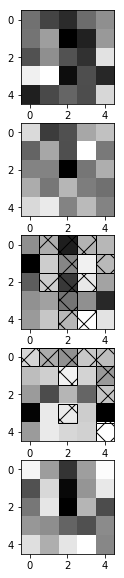

In [115]:
# 觀察 hidden layer neurons 的 weights

width = 2
fig, axes = plt.subplots(num_hidden, 1, figsize = (width*1, width * num_hidden))

for n in range(5):
    ax = axes[n]
    show_weights(network, n, ax)

In [116]:
def predict(input):
    return feed_forward(network, input)[-1]  # 使用訓練好的 network 來辨識 input

# 對所有的 inputs 輸出辨識 結果
for i, input in enumerate(inputs):
    outputs = predict(input)
    print(i, [round(p,2) for p in outputs])

0 [0.79, 0.0, 0.0, 0.08, 0.22, 0.07, 0.0, 0.14, 0.02, 0.17]
1 [0.0, 0.79, 0.11, 0.22, 0.01, 0.02, 0.0, 0.12, 0.0, 0.05]
2 [0.0, 0.1, 0.87, 0.1, 0.01, 0.05, 0.06, 0.0, 0.09, 0.04]
3 [0.01, 0.13, 0.02, 0.16, 0.02, 0.03, 0.0, 0.11, 0.01, 0.07]
4 [0.14, 0.0, 0.0, 0.05, 0.17, 0.11, 0.05, 0.0, 0.1, 0.14]
5 [0.02, 0.0, 0.01, 0.05, 0.11, 0.11, 0.1, 0.0, 0.16, 0.12]
6 [0.01, 0.0, 0.06, 0.03, 0.12, 0.16, 0.42, 0.0, 0.44, 0.12]
7 [0.09, 0.13, 0.0, 0.19, 0.03, 0.02, 0.0, 0.82, 0.0, 0.09]
8 [0.01, 0.0, 0.05, 0.04, 0.11, 0.14, 0.31, 0.0, 0.36, 0.11]
9 [0.07, 0.0, 0.0, 0.07, 0.1, 0.07, 0.01, 0.0, 0.04, 0.12]


In [ ]:
# 辨識 臨時給定的 input

print(""".@@@.
...@@
.@@@.
...@@
.@@@.""")
print([round(x, 2) for x in
       predict( [0,1,1,1,0,  # .@@@.
                 0,0,0,1,1,  # ...@@
                 0,1,1,1,0,  # .@@@.
                 0,0,0,1,1,  # ...@@
                 0,1,1,1,0]) # .@@@.
      ]) 

In [ ]:
# 辨識 臨時給定的 input

print(""".@@@.
@..@@
.@@@.
@..@@
.@@@.""")
print([round(x, 2) for x in 
       predict( [0,1,1,1,0,  # .@@@.
                 1,0,0,1,1,  # @..@@
                 0,1,1,1,0,  # .@@@.
                 1,0,0,1,1,  # @..@@
                 0,1,1,1,0]) # .@@@.
      ])